# Deep Learning in Medicine - Spring 2024
### BMSC-GA 4493, BMIN-GA 3007 
### Homework 2 - Convolutional Neural Networks





**Note:** If you need to write mathematical terms, you can type your answeres in a Markdown Cell via LaTex

See: <a href="https://stackoverflow.com/questions/13208286/how-to-write-latex-in-ipython-notebook">here</a> if you have issues. To see basic LaTex notation see: <a href="https://en.wikibooks.org/wiki/LaTeX/Mathematics"> here </a>.

**Submission instruction**: Upload and Submit a zipped folder named netid_hw2 consisting of your final jupyter notebook and necessary files in <a href='https://brightspace.nyu.edu/d2l/home/158477'>Brightspace</a>. If you use code or script from web, please give a link to the code in your answers. Not providing the reference of the code used will reduce your points!!

**Submission deadline: Saturday March 23rd 2024 --> No Extensions!!**

## Topics & weightage -


1.   Convolutions (30)
2.   Network design (15)
3.   Literature review (19)
4.   Deep CNN design for disease classification (36)



## Question 1: Convolutions (Total 30 points)

### 1.1 Convolutions from **scratch** for image processing (11 points)

In [44]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time


In [2]:
def plot_image(img: np.array):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray');
    
def plot_two_images(img1: np.array, img2: np.array):
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2, cmap='gray')

#### 1 point

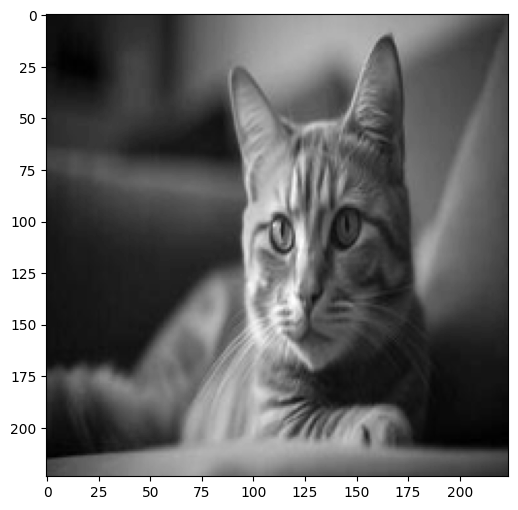

In [3]:
# TODO: Load any image of your choice and display (plot) the resized image (224*224) in grayscale using the plot_image function. 
# OR you can also utilize the sample image provided --> cat.png
# (None of these transformations are mandatory, but they make our job a bit easier, 
# as there’s only one color channel to apply convolution to)

image = Image.open('cat.png')
image = image.resize((224, 224))
image = ImageOps.grayscale(image) 
image = np.array(image)
plot_image(image)

In [4]:
# Defining Filters 
sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

blur = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125,  0.25,  0.125],
    [0.0625, 0.125, 0.0625]
])

outline = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

#### 1.5 points

In [5]:
def calculate_target_size(img_size: int, kernel_size: int) -> int:
    num_pixels = img_size - (kernel_size - 1)
    '''
    Helper function to calculate the image size after applying the convolution
    Basically calculates how many windows of the filter size you can fit to an image (assuming square image)
    Applying a convolution to an image will make it smaller (assuming no padding). 
    The filter size determined how smaller the image will be after convolving.

    Args:
    img_size: size of one dimension of the input image (assuming its a square image)
    kernel_size: size of one dimension of the kernel (a square kernel)

    Returns:
    num_pixels: number of pixels in the resultant output image

    '''
    #TODO: Write a generic function that inputs an image size & kernel size to calculate the final size of the output
    num_pixels = img_size - (kernel_size - 1)
    
    return num_pixels

#### 3 points

In [6]:
def convolve(img: np.array, kernel: np.array) -> np.array:
    '''
    The convolve() function calculates the target size and creates 
    a matrix of zeros with that shape, iterates over all rows and 
    columns of the image matrix, subsets it, and applies the convolution.

    Args:
    img: the input image as a numpy array
    kernel: kernel as a numpy array

    Returns:
    convolved_img: output image after sliding the kernel over the input image  
    '''
    #TODO: implement the convolve function 
    #Iterate over all rows and columns of the input image matrix.
    #Subset the image based on the kernel size at each position and apply the convolution operation.
    
    target_size = calculate_target_size(img.shape[0], kernel.shape[0]) #Calculate size
    convolved_img = np.zeros([target_size, target_size]) #Initialize convolved image
    
    #Iterate over all rows and columns of the input
    for i in range(target_size):
        for j in range(target_size):
            subset = img[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            convolved_img[i, j] = np.sum(subset * kernel)
    
    return convolved_img

#### 0.5 point

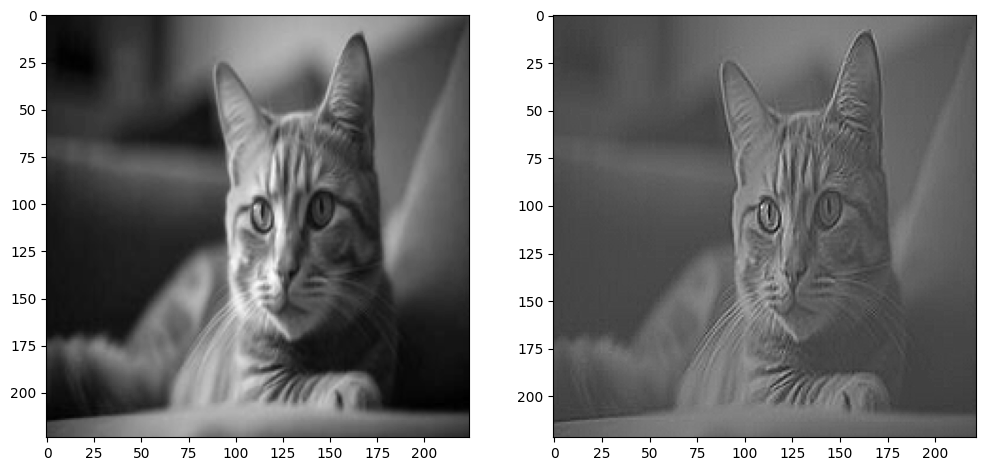

In [7]:
#TODO: use the convolved function & the sharpen filter to obtain a sharpened image of your original input 
#TODO: print the sharpened image array named img_sharpened
#TODO: Use the plot_two_images function to plot the original image and sharpened image side by side

img_sharpened = convolve(image, sharpen)
plot_two_images(image, img_sharpened)


#### 0.5 point

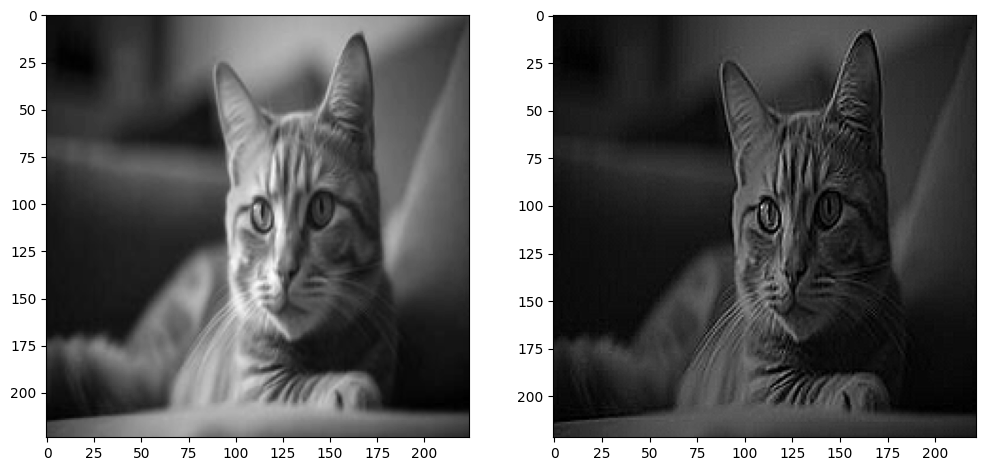

In [8]:
#TODOThe sharpened image is a little dull. Thats because some values in the sharpened image 
# are less than zero. Write a function that uses 0 as a threshold and converts all pixel 
# values less than zero to zero.

def negative_to_zero(img: np.array) -> np.array:
    '''
    Args:
    img: numpy array of image

    Returns:
    img: all values less than zero are assigned zero in original image
    '''
    img[img<0]=0
    return img

#TODO: Use the plot_two_images function to plot the original image and negative_to_zero sharpened image side by side
img_neg_to_zero_sharpened = negative_to_zero(img_sharpened)
plot_two_images(image, img_neg_to_zero_sharpened)


#### 1 point

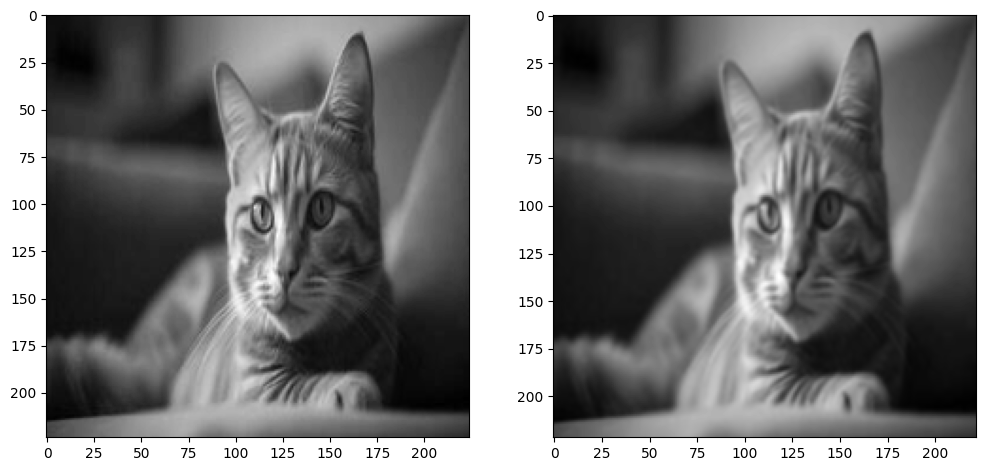

In [9]:
#TODO: use the convolved function & the blur filter to obtain a sharpened image of your original input 
#TODO: print the blurred image array named img_blurred
#TODO: Use the plot_two_images function to plot the original image and blurred image side by side
img_blurred = convolve(image, blur)
plot_two_images(image, img_blurred)

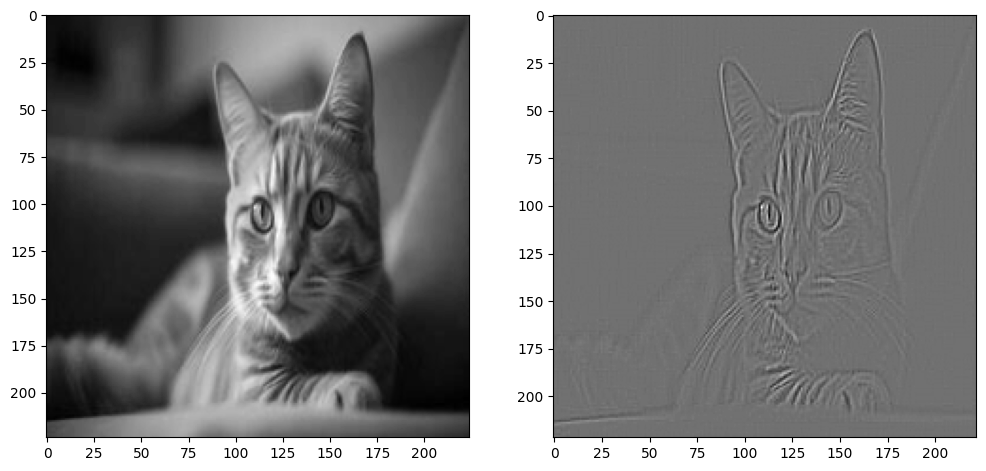

In [10]:
#TODO: use the convolved function & the outline filter to obtain a outlined image of your original input 
#TODO: print the outlined image array named img_outlined
#TODO: Use the plot_two_images function to plot the outlined image and original image side by side
img_outlined = convolve(image, outline)
plot_two_images(image, img_outlined)

#### Convolutions with padding:

Padding is essentially a “black” border around the image. It’s black because the values are zeros, and zeros represent the color black. The black borders don’t have any side effects on the calculations, as it’s just a multiplication with zero.

#### 0.5 point

In [11]:
def get_padding_width_per_side(kernel_size: int) -> int:
    '''
    Function that returns the number of pixels we need to 
    pad the image with on a single side, depending on the kernel size

    Args:
    kernel_size: filter size 

    Returns:
    padding_width 
    '''
    #TODO: Simple integer division by 2
    padding_width = kernel_size // 2

    return padding_width

In [12]:
#--> uncomment this section
pad_3x3 = get_padding_width_per_side(3)
pad_5x5 = get_padding_width_per_side(5)

#### 1.5 points

In [13]:
def add_padding_to_image(img: np.array, padding_width: int) -> np.array:
    '''
    Function that adds padding to the image. 
    First, the function declares a matrix of zeros with a shape of image.shape + padding * 2. 
    The function then indexes the matrix so the padding is ignored and changes the zeros with the actual image values.

    Args:
      img: Original image numpy array
      padding_width: obtained in the get padding function earlier

    Returns:
      img_with_padding: padded image
    '''
#     #TODO: take your image and a padding width as input and return the image with the padding added
    img_with_padding = np.zeros((img.shape[0] + 2 * padding_width, img.shape[1] + 2 * padding_width))  #Initialize image with padding
    
    img_with_padding[padding_width:padding_width+img.shape[0], padding_width:padding_width+img.shape[1]] = img #Put image in center
    
    
    return img_with_padding

#### Q: In the above function add_padding_to_image, explore the possible reason for the multiplication of padding_width by 2 in step 1 (1 point). 

FINISH

#### 0.5 point

(226, 226)


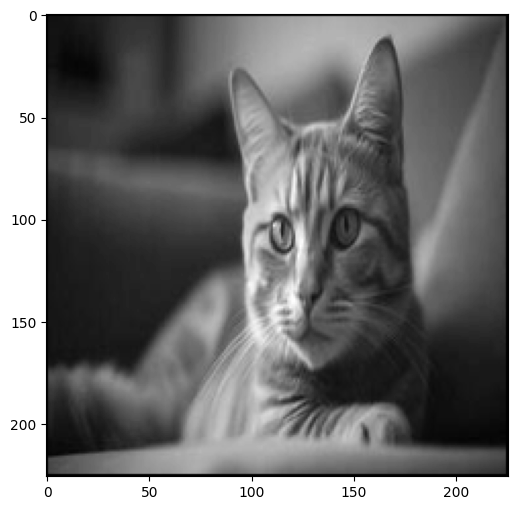

In [14]:
#TODO: Use the add_padding_to_image function to obtain the padded image (kernel size of 3)
padding_width = get_padding_width_per_side(3)
img_with_padding_3x3 = add_padding_to_image(image,padding_width)

# --> UNCOMMENT two lines below
print(img_with_padding_3x3.shape)
plot_image(img_with_padding_3x3)

(228, 228)


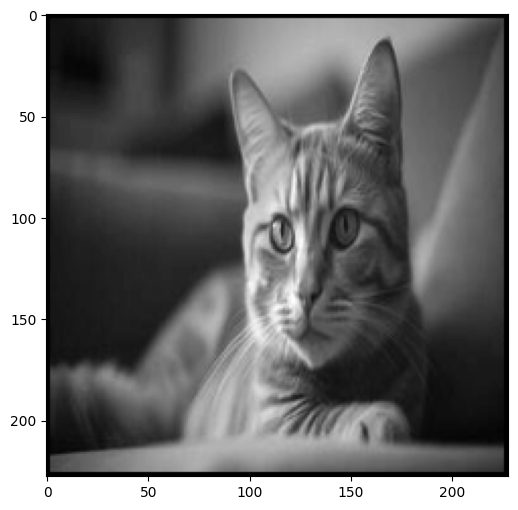

In [15]:
#TODO: Use the add_padding_to_image function to obtain the padded image (kernel size of 5)
padding_width = get_padding_width_per_side(5)
img_with_padding_5x5 = add_padding_to_image(image,padding_width)

# --> UNCOMMENT two lines below
print(img_with_padding_5x5.shape)
plot_image(img_with_padding_5x5)

#### 1 point

Shape of padded sharpended image: (224, 224)


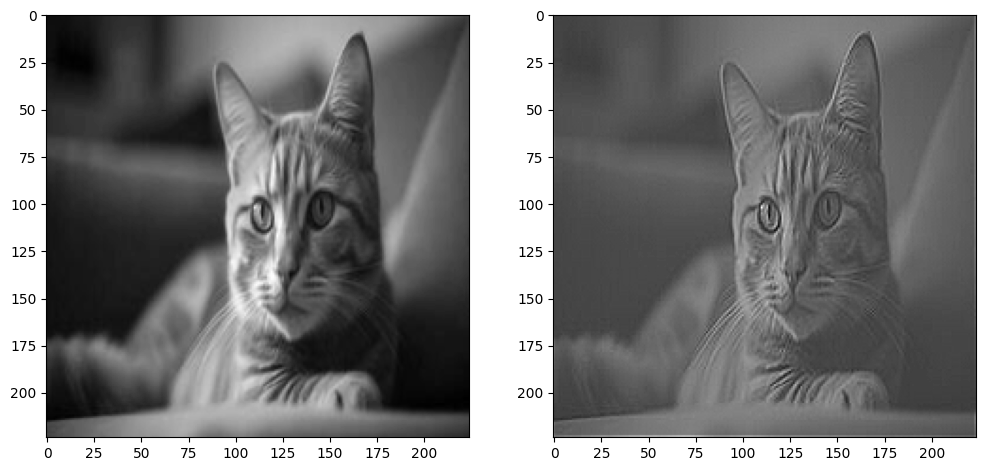

In [16]:
#TODO: use the convolved function & the sharpen filter to obtain a sharpened image of your padded image obtained from add_padding_to_image function 
#TODO: print the shape of the obtain sharpened image (obtained after padding)
#TODO: plot the original image and the sharpened image (obtained after padding) side by side using the plot_two_images function

img_padded_sharpened = convolve(img_with_padding_3x3, sharpen)
print('Shape of padded sharpended image:', img_padded_sharpened.shape)
plot_two_images(image, img_padded_sharpened)

### 1.2: Convolutional Layers (4 points)

We have a 3x5x5 image (3 channels) and three 3x3x3 convolution kernels as pictured. Bias term for each feature map is also provided. For the questions below, please provide the feature/activation maps requested, please provide the python code that you used to calculate the maps

Hint: An image tensor should be [batch size, channels, height, weight], kernels/filters tensor should be [number of filters (output channels), filter_size_1 (input channels), filter_size_2, filter_size_3].

<img src="https://github.com/nyumc-dl/BMSC-GA-4493-Spring2022/blob/main/Homework2/HW2_picture1.png?raw=1">

### 1.2 What will be the dimension of the feature maps after we forward propogate the image using the given convolution kernels for the following (a) - (d)

In [17]:
x = np.load('q1_input.npy')
w = np.load('q1_Filters.npy')

In [18]:
#Adding stride to convolution function
def convolve_with_stride(img: np.array, kernel: np.array, stride: int) -> np.array:
    num_images = img.shape[0]
    target_length = (img.shape[1] - kernel.shape[1]) // stride + 1
    convolved_imgs = np.zeros([num_images, target_length, target_length])

    for n in range(num_images):
        for i in range(0, img.shape[1] - kernel.shape[0] + 1, stride):
            for j in range(0, img.shape[2] - kernel.shape[1] + 1, stride):
                subset = img[n, i:i+kernel.shape[0], j:j+kernel.shape[1]]
                convolved_imgs[n, i//stride, j//stride] = np.sum(subset * kernel[n])
    return np.sum(convolved_imgs, axis=0)

#### 1.2.a) (1 point)
__stride=1, without zero padding?__

3x3x3

In [19]:
#See above convolve_with_stride function 
stride = 1
target_length = (x.shape[1] - w.shape[1]) // stride + 1
feature_map = np.zeros([3, target_length, target_length])

for i, kernel in enumerate(w):
    feature_map[i] = convolve_with_stride(x, kernel, stride)
    
print('Feature Map:\n', feature_map)
print('\nFeature Map Shape:\n', feature_map.shape)


Feature Map:
 [[[-14.   4. -13.]
  [ -9.  -3. -25.]
  [  9.  -9. -12.]]

 [[ 17.  18.  24.]
  [  6.  38. -12.]
  [ 23.  31.  33.]]

 [[ 18.   5. -13.]
  [  5.   3.  -6.]
  [  2.   1. -12.]]]

Feature Map Shape:
 (3, 3, 3)


In [20]:
# Reshape the input data to add batch dimension
x_tensor = torch.tensor(x, dtype=torch.float32)
w_tensor = torch.tensor(w, dtype=torch.float32)
input_data = x_tensor.unsqueeze(0)

# Perform convolution without padding and stride 1
conv = torch.nn.functional.conv2d(input_data, w_tensor, stride=1)

print(conv)

tensor([[[[-14.,   4., -13.],
          [ -9.,  -3., -25.],
          [  9.,  -9., -12.]],

         [[ 17.,  18.,  24.],
          [  6.,  38., -12.],
          [ 23.,  31.,  33.]],

         [[ 18.,   5., -13.],
          [  5.,   3.,  -6.],
          [  2.,   1., -12.]]]])


#### 1.2.b) (1 point) 
__stride=2, padding = 1?__

3x3x3

In [21]:
#See above convolve_with_stride function 
stride = 2
padding_width = 1

x_with_padding = np.zeros((3, x.shape[1] + 2 * padding_width, x.shape[2] + 2 * padding_width))  #Initialize image with padding

for i,channel in enumerate(x):
    x_with_padding[i, padding_width:padding_width+x.shape[1], padding_width:padding_width+x.shape[2]] = x[i] #Put image in center
    
    
target_length = (x_with_padding.shape[1] - w.shape[1]) // stride + 1
feature_map = np.zeros([3, target_length, target_length])

for i, kernel in enumerate(w):
    feature_map[i] = convolve_with_stride(x_with_padding, kernel, stride)
    
print('Feature Map:\n', feature_map)
print('\nFeature Map Shape:\n', feature_map.shape)


Feature Map:
 [[[  2. -26. -25.]
  [ 21.  -3. -13.]
  [  8. -11.  -1.]]

 [[  7.  32.  29.]
  [ 13.  38.  33.]
  [  9.  24.  -1.]]

 [[-19.   2.  14.]
  [-18.   3. -13.]
  [  6.   8.  -6.]]]

Feature Map Shape:
 (3, 3, 3)


In [22]:
# Reshape the input data to add batch dimension
x_tensor = torch.tensor(x_with_padding, dtype=torch.float32)
w_tensor = torch.tensor(w, dtype=torch.float32)
input_data = x_tensor.unsqueeze(0)

# Perform convolution without padding and stride 1
conv = torch.nn.functional.conv2d(input_data, w_tensor, stride=2)

print(conv)

tensor([[[[  2., -26., -25.],
          [ 21.,  -3., -13.],
          [  8., -11.,  -1.]],

         [[  7.,  32.,  29.],
          [ 13.,  38.,  33.],
          [  9.,  24.,  -1.]],

         [[-19.,   2.,  14.],
          [-18.,   3., -13.],
          [  6.,   8.,  -6.]]]])


#### 1.2.c) (1 point)
__stride=3, padding = 2?__

3x4x4

In [23]:
#See above convolve_with_stride function 
stride = 2
padding_width = 2

x_with_padding = np.zeros((3, x.shape[1] + 2 * padding_width, x.shape[2] + 2 * padding_width))  #Initialize image with padding

for i,channel in enumerate(x):
    x_with_padding[i, padding_width:padding_width+x.shape[1], padding_width:padding_width+x.shape[2]] = x[i] #Put image in center
    
    
target_length = (x_with_padding.shape[1] - w.shape[1]) // stride + 1
feature_map = np.zeros([3, target_length, target_length])

for i, kernel in enumerate(w):
    feature_map[i] = convolve_with_stride(x_with_padding, kernel, stride)
    
print('Feature Map:\n', feature_map)
print('\nFeature Map Shape:\n', feature_map.shape)


Feature Map:
 [[[  8.   0. -12.  -9.]
  [ 17. -14. -13.   4.]
  [  3.   9. -12.  -2.]
  [  2.   8.   2.   1.]]

 [[ -6.  19.  12.  13.]
  [-10.  17.  24.  20.]
  [ -4.  23.  33.   4.]
  [  4.   0.   9.   6.]]

 [[-10.  -6.  -7.   7.]
  [  2.  18. -13.   5.]
  [ -4.   2. -12.  11.]
  [ -2.  -4.  -1.  -3.]]]

Feature Map Shape:
 (3, 4, 4)


In [24]:
# Reshape the input data to add batch dimension
x_tensor = torch.tensor(x_with_padding, dtype=torch.float32)
w_tensor = torch.tensor(w, dtype=torch.float32)
input_data = x_tensor.unsqueeze(0)

# Perform convolution without padding and stride 1
conv = torch.nn.functional.conv2d(input_data, w_tensor, stride=2)

print(conv)

tensor([[[[  8.,   0., -12.,  -9.],
          [ 17., -14., -13.,   4.],
          [  3.,   9., -12.,  -2.],
          [  2.,   8.,   2.,   1.]],

         [[ -6.,  19.,  12.,  13.],
          [-10.,  17.,  24.,  20.],
          [ -4.,  23.,  33.,   4.],
          [  4.,   0.,   9.,   6.]],

         [[-10.,  -6.,  -7.,   7.],
          [  2.,  18., -13.,   5.],
          [ -4.,   2., -12.,  11.],
          [ -2.,  -4.,  -1.,  -3.]]]])


#### 1.2.d) (1 point) 
__A dilated convolution with stride=1, dilation rate=2 and padding=0?__

3x1x1

In [25]:
def convolve_with_stride_and_dilation(img: np.array, kernel: np.array, stride: int, dilation: int) -> np.array:
    num_images = img.shape[0]
    target_length = (img.shape[1] - (kernel.shape[1] - 1) * dilation - 1) // stride + 1
    convolved_imgs = np.zeros([num_images, target_length, target_length])

    for n in range(num_images):
        for i in range(0, img.shape[1] - (kernel.shape[1] - 1) * dilation, stride):
            for j in range(0, img.shape[2] - (kernel.shape[2] - 1) * dilation, stride):
                subset = img[n, i:i + kernel.shape[1] * dilation:dilation, j:j + kernel.shape[2] * dilation:dilation]
                convolved_imgs[n, i // stride, j // stride] = np.sum(subset * kernel[n])
    return np.sum(convolved_imgs, axis=0)

In [26]:
#See above convolve_with_stride_and_dilation function 
stride = 1
dilation = 2
    
target_length = (x.shape[1] - (kernel.shape[1] - 1) * dilation - 1) // stride + 1
feature_map = np.zeros([3, target_length, target_length])

for i, kernel in enumerate(w):
    feature_map[i] = convolve_with_stride_and_dilation(x, kernel, stride, dilation)
    
print('Feature Map:\n', feature_map)
print('\nFeature Map Shape:\n', feature_map.shape)


Feature Map:
 [[[-17.]]

 [[ 26.]]

 [[  3.]]]

Feature Map Shape:
 (3, 1, 1)


In [27]:
# Reshape the input data to add batch dimension
x_tensor = torch.tensor(x, dtype=torch.float32)
w_tensor = torch.tensor(w, dtype=torch.float32)
input_data = x_tensor.unsqueeze(0)

# Perform convolution without padding and stride 1
conv = torch.nn.functional.conv2d(input_data, w_tensor, stride=1, dilation=2)

print(conv)

tensor([[[[-17.]],

         [[ 26.]],

         [[  3.]]]])


__1.3 Feature Dimensions of Convolutional Neural Network (4*0.5 points)__

In this problem, we compute output feature shape of convolutional layers and pooling layers, which are building blocks of CNN. Let’s assume that input feature shape is W × H × C, where W is the width, H is the height and C is the number of channels of input feature. 




#### 1.3 (a) A convolutional layer has 4 hyperparameters: the filter size(K), the padding size (P), the stride step size (S) and the number of filters (F). How many weights and biases are in this convolutional layer? And what is the shape of output feature that this convolutional layer produces? 


Answer) 








#### 1.3 (b) A pooling layer has 2 hyperparameters: the stride step size(S) and the filter size (K). What is the output feature shape that this pooling layer produces? 

Answer) 





#### 1.3 (c) Let’s assume that we have the CNN model which consists of L successive convolutional layers and the filter size is K and the stride step size is 1 for every convolutional layer. Then what is the receptive field size? 

Answer) 








#### 1.3 (d) Consider a downsampling layer (e.g. pooling layer and strided convolution layer). In this problem, we investigate pros and cons of downsampling layer. This layer reduces the output feature resolution and this implies that the output features loose the certain amount of spatial information. Therefore when we design CNN, we usually increase the channel length to compensate this loss. For example, if we apply the max pooling layer with kernel size of 2 and stride size of 2, we increase the output feature size by a factor of 2. If we apply this max pooling layer, how much the receptive field increases? Explain the advantage of decreasing the output feature resolution with the perspective of reducing the amount of computation.

Answer)

### 1.4) (6 points)
Use the pytorch package to calculate feature/activation maps. Write a code which takes 3x5x5 image and performs a 2D convolution operation (with stride = 1 and zero padding) using 3x3x3 filters provided on the picture. After convolution layer use leaky ReLU activation function (with negative slope 0.01) and Max-Pooling operation with required parameters to finally obtain output of dimension 3x1x1. Provide the code, feature maps obtained from convolution operation, activation maps, and feature maps after Max-Pooling operation.

**Hint:** You can refer to [AdaptiveMaxPool2d](https://pytorch.org/docs/stable/nn.html#adaptivemaxpool2d) to get desired dimension output from Pooling layer.

In [28]:
# starter code to load image:x, kernel weights:w and bias:b

x = np.load('q1_input.npy')
w = np.load('q1_Filters.npy')
b = np.load('q1_biases.npy')

#Convert to tensors:
x = torch.tensor(x).float()
w = torch.tensor(w).float()
b = torch.tensor(b).float()


class ConvNet(nn.Module):
    def __init__(self, kernel, biases):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, kernel_size=3, stride=1) #Convolutional layer
        self.conv1.weight = nn.Parameter(kernel) #Kernel
        self.conv1.bias = nn.Parameter(biases) #Biases
        self.leaky_relu = nn.LeakyReLU(0.01) #Leaky ReLU activation function
        self.max_pool = nn.AdaptiveMaxPool2d((1))
        
    def forward(self, x):
        x = self.conv1(x)
        print("Feature maps after convolution operation:\n",x)
        
        x = self.leaky_relu(x)
        print("\nFeature maps after activation function:\n",x)

        x = self.max_pool(x)
        print("\nFeature maps after max pooling:\n",x)

        return x

#Initialize Model:
model = ConvNet(w, b)

#Forward Pass:
output = model(x)


Feature maps after convolution operation:
 tensor([[[-13.,   5., -12.],
         [ -8.,  -2., -24.],
         [ 10.,  -8., -11.]],

        [[ 16.,  17.,  23.],
         [  5.,  37., -13.],
         [ 22.,  30.,  32.]],

        [[ 16.,   3., -15.],
         [  3.,   1.,  -8.],
         [  0.,  -1., -14.]]], grad_fn=<SqueezeBackward1>)

Feature maps after activation function:
 tensor([[[-1.3000e-01,  5.0000e+00, -1.2000e-01],
         [-8.0000e-02, -2.0000e-02, -2.4000e-01],
         [ 1.0000e+01, -8.0000e-02, -1.1000e-01]],

        [[ 1.6000e+01,  1.7000e+01,  2.3000e+01],
         [ 5.0000e+00,  3.7000e+01, -1.3000e-01],
         [ 2.2000e+01,  3.0000e+01,  3.2000e+01]],

        [[ 1.6000e+01,  3.0000e+00, -1.5000e-01],
         [ 3.0000e+00,  1.0000e+00, -8.0000e-02],
         [ 0.0000e+00, -1.0000e-02, -1.4000e-01]]],
       grad_fn=<LeakyReluBackward0>)

Feature maps after max pooling:
 tensor([[[10.]],

        [[37.]],

        [[16.]]], grad_fn=<AdaptiveMaxPool2DBackward0>)


### 1.5) (7 points)
Use the pytorch package to calculate feature/activation maps of a residual unit as depicted in Figure 2 of https://arxiv.org/pdf/1512.03385.pdf as well as on the figure above.


<img src="https://github.com/nyumc-dl/BMSC-GA-4493-Spring2022/blob/main/Homework2/HW2_picture2.png?raw=1" width="150">

__Write a code which takes 3x5x5 input image and performs two 2D convolution operations using the filters provided on the figure. Please use the three 3x3x3 filters for the two Convolution layers. You need to set a suitable padding size for the convolution operations. After the convolution layers and after the residual addition use ReLU activation function. Provide the code and feature maps obtained from each convolution operation, activation maps, and the last activation map obtained from the residual unit.__

In [29]:
x = np.load('q1_input.npy')
w = np.load('q1_Filters.npy')
b = np.load('q1_biases.npy')

#Convert to tensors:
x = torch.tensor(x).float()
w = torch.tensor(w).float()
b = torch.tensor(b).float()


class ConvNet2(nn.Module):
    def __init__(self, kernel, biases):
        super(ConvNet2, self).__init__()
        padding = 1
        self.conv1 = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=padding) #Convolutional layer
        self.conv1.weight = nn.Parameter(kernel) #Kernel
        self.conv1.bias = nn.Parameter(biases) #Biases
        self.conv2 = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=padding) #Convolutional layer 2
        self.conv2.weight = nn.Parameter(kernel) #Kernel
        self.conv2.bias = nn.Parameter(biases) #Biases
        self.relu = nn.ReLU() #ReLU activation function
        
    def forward(self, x):
        x1 = self.conv1(x)
        print("Feature maps after first convolution operation:\n",x1)
        x1 = self.relu(x1)
        print("\nFeature maps after first activation function:\n",x1)
        x2 = self.conv1(x1)
        print("Feature maps after second convolution operation:\n",x2)
        x3 = x + x2
        print("\nFeature maps after residual addition:\n",x3)
        x3 = self.relu(x3)
        print("\nFeature maps after second activation function:\n",x3)

        return x

#Initialize Model:
model2 = ConvNet2(w, b)

#Forward Pass:
output = model2(x)

Feature maps after first convolution operation:
 tensor([[[  3.,  -6., -25.,  -1., -24.],
         [ -6., -13.,   5., -12., -15.],
         [ 22.,  -8.,  -2., -24., -12.],
         [  2.,  10.,  -8., -11.,  -5.],
         [  9.,   0., -10.,  17.,   0.]],

        [[  6.,  27.,  31.,  16.,  28.],
         [ 12.,  16.,  17.,  23.,  16.],
         [ 12.,   5.,  37., -13.,  32.],
         [ 18.,  22.,  30.,  32.,  14.],
         [  8.,  -9.,  23.,  -3.,  -2.]],

        [[-21.,  -7.,   0.,  -8.,  12.],
         [  0.,  16.,   3., -15., -14.],
         [-20.,   3.,   1.,  -8., -15.],
         [-27.,   0.,  -1., -14.,   1.],
         [  4.,  -3.,   6.,   2.,  -8.]]], grad_fn=<SqueezeBackward1>)

Feature maps after first activation function:
 tensor([[[ 3.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  5.,  0.,  0.],
         [22.,  0.,  0.,  0.,  0.],
         [ 2., 10.,  0.,  0.,  0.],
         [ 9.,  0.,  0., 17.,  0.]],

        [[ 6., 27., 31., 16., 28.],
         [12., 16., 17., 23., 16.],


### 1.6 (2 points)
__Describe the key design paramters of inception v3 (https://arxiv.org/pdf/1512.00567.pdf) and explain how it avoids overfitting of data.__ 

# Question 2: Network design parameters for disease classification (Total 15 points)

Disease classification is a common problem in medicine. There are many ways to solve this problem. Goal of this question is to make sure that you have a clear picture in your mind about possible techniques that you can use in such a classification task.

Assume that we have a 10K images in a dataset of computed tomography (CTs). For each image, the dimension is 16x256x256 and we have the label for each image. The label of each image defines which class the image belongs (lets assume we have 4 different disease classes in total). You will describe your approach of classifying the disease for the techniques below. Make sure you do not forget the bias term. You can either design your proposed network by explaining it explicitely or you can provide the pytorch code which designs the network for questions 2.1.a, 2.2.a, and 2.3.a


In [30]:
# starter code
import torch
# you can generate a random image tensor for batch_size 8
x = torch.Tensor(8,1,16,256,256).normal_().type(torch.FloatTensor)

### 2.1.a) (2 points)
__Design a multi layer perceptron (MLP) with a two hidden layer which takes an image as input (by reshaping it to a vector: lets call this a vectorized image). Our network has to first map the vectorized images to a vector of 512, then to 256 in the second hidden layer and then to 128 in the third hidden layer and finally feeds this vector to a fully connected layer to get the probability of 5 tissue classes.__ 

### 2.1.b) (2 points)
__Clearly mention the sizes for your input and output at each layer until you get final output vector with 5 tissue classes in 64x128x128 voxels(volumetric pixel)__

### 2.1.c) (1 points)
__How many parameters you need to fit for your design? How does adding another hidden layer (64 neurons) will effect the number of parameters to use?__

### 2.2.a) (2 points)
__Design a one layer convolutional neural network which first maps the images to a vector of 256 and then 128 (both with the help of convolution and pooling operations) then feeds this vector to a fully connected layer to get the probability of 5 disease classes.__

### 2.2.b) (2 points)
__Clearly mention the sizes for your input, kernel, pooling, and output at each step until you get final output vector with 5 probabilities__

### 2.2.c) (1 point) 
__How many parameters you need to fit for your design?__

### 2.2.d) (2 points)
__Now increase your selected convolution kernel size by 4 in each direction. Describe the effect of using small vs large filter size during convolution.__

## 2.3) (3 points)
__Explain your findings regading different types of neural networks and building blocks based on your observations from 2.1 and 2.2.__ 

# Question 3: Literature Review: ChestX-ray8 (Total 19 points)
Read this paper:

Pranav Rajpurkar, Jeremy Irvin, et al. 
CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning https://arxiv.org/abs/1711.05225


We are interested in understanding the goal of the task performed, the methods proposed, technical aspects of the implementation, and possible future work. After you read the full article answer the following questions. Describe your answers in your own words.  

#### 3.1) (2 points) 

__What was the underlying goal of this paper? What were the challenges in detection of pneumonia that this paper aimed at solving? What was the key motivation?__ 


#### 3.2)  (3 points)
__Describe the machine learning task (segmentation, classification, regression, etc?) that was attempted in this paper. Further describe the learning algorithm used (supervised, unsupervised, ..etc.) and the reason was using this algorithm.__ 

#### 3.3) (2.5 points)
__How does the proposed architecture in this paper compare with the previous State of the art? Give details on the modifications and improvements, and reasons for why you think these worked.__

#### 3.4) (2 points)
__Describe the CNN architecture used along with training details (A roadflow that explains the entire training process with details on the batch_size, optimizer, loss function, model weights, learning rate, etc. Also try to infer why were these paramters and hyperparamters chosen for this specific task.__ 


#### 3.5) (2.5 points)

__How was the model evaluated? What were the metrics utilized? List down reasons of using these metrics over all others.__  




#### 3.6) (2.5 points)

__Explain model interpretation through class activation mapping. Discuss the role of Class Activation Maps (CAMs) in CheXNet.?__

#### 3.7) (2 points)
__What was the kind of preprocessing the dataset went through? Explain reasons for each data transformation/preprocessing step.__

#### 3.8) (2.5 points)

__In the paper CAMs (class activation mappings) are used for visualisation. Can this method be used for any CNN ? Describe the architectural requirements for getting CAM visualisations.__

# Question 4: Deep CNN design for disease classification (Total 36 points)

In this part of the howework, we will focus on classifiying the lung disease using chest x-ray dataset provided by NIH (https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community). You should be familiar with the dataset after answering Question 3.

You need to use HPC for training part of this question, as your computer's CPU will not be fast enough to compute learning iterations. Please read the HPC instruction first. In case you use HPC, please have your code/scripts uploaded under the questions and provide the required plots and tables there as well. If you run the HW2 jupter script with Squash File System and Singularity on GCP, you can find the data under /images folder. We are interested in classifying pneumothorax, cardiomegaly and infiltration cases. By saying so we have 3 classes that we want to identify by modelling a deep CNN.

First, you need to work on Data_Entry_2017_v2020.csv file to identify cases/images that has infiltration, pneumothorax, and cardiomegaly. This file can be downloaded from https://nihcc.app.box.com/v/ChestXray-NIHCC

## 4.1) Train, Test, and Validation Sets (0.5 point)
Write a script to read data from Data_Entry_2017.csv and process to obtain 3 sets (train, validation and test). By using 'Finding Labels' column, define a class that each image belongs to, in total you can define 3 classes:
- 0 cardiomegaly
- 1 pneumothorax
- 2 infiltration

Generate a train, validation and test set by splitting the whole dataset containing specific classes (0, 1, and 2)  by 70%, 10% and 20%, respectively. Test set will not be used during modelling but it will be used to test your model's accuracy. Make sure you have similar percentages of different cases in each subset. Provide statistics of the number of classess in your subsets. (you do not need to think about splitting the sets based on subjects for this homework. In general, we do not want images from the same subject to appear in both train and test sets!!) 

Write a .csv files defining the samples in your train, validation and test set with names: train.csv, validation.csv, and test.csv. Submit these files with your homework. 

In [31]:
# import os
# import random
# from sklearn.preprocessing import LabelEncoder

# image_folder = "/scratch/yc7087/shared/all_images"
# data_df = pd.read_csv('Data_Entry_2017_v2020.csv')

# #Define Classes 
# le = LabelEncoder()
# data_df['Class'] = le.fit_transform(data['Finding Labels'])

# # Map original labels to encoded labels
# label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# # Split the data into train, validation, and test sets
# train_ratio = 0.7
# val_ratio = 0.1
# test_ratio = 0.2

# # Shuffle the data
# data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# # Split indices
# num_samples = len(data)
# num_train = int(train_ratio * num_samples)
# num_val = int(val_ratio * num_samples)

# train_indices = list(range(num_train))
# val_indices = list(range(num_train, num_train + num_val))
# test_indices = list(range(num_train + num_val, num_samples))

# # Create train, validation, and test sets
# train_set = data.iloc[train_indices]
# val_set = data.iloc[val_indices]
# test_set = data.iloc[test_indices]

# # Check class distribution in each set
# train_class_counts = train_set['Class'].value_counts()
# val_class_counts = val_set['Class'].value_counts()
# test_class_counts = test_set['Class'].value_counts()

# # Write CSV files for train, validation, and test sets
# train_set.to_csv(os.path.join(data_path, "train.csv"), index=False)
# val_set.to_csv(os.path.join(data_path, "validation.csv"), index=False)
# test_set.to_csv(os.path.join(data_path, "test.csv"), index=False)

# # Print statistics
# print("Train Set Class Distribution:")
# print(train_class_counts)
# print("\nValidation Set Class Distribution:")
# print(val_class_counts)
# print("\nTest Set Class Distribution:")
# print(test_class_counts)
# print("\nLabel Mapping:")
# print(label_mapping)



## 4.2) Data preparation before training (2 points)
From here on, you will use HW2_trainSet.csv, HW2_testSet.csv and HW2_validationSet.csv provided under github repo for defining train, test and validation set samples instead of the csv files you generate on Question 4.1.


There are multiple ways of using images as an input during training or validation. Here, you will use torch Dataset class  (http://pytorch.org/tutorials/beginner/data_loading_tutorial.html). We provided an incomplete dataloader code below. Please add your code and complete it.

In [32]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from skimage import color

class ChestXrayDataset(Dataset):
    """Chest X-ray dataset from https://nihcc.app.box.com/v/ChestXray-NIHCC."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.data_frame.iloc[idx, 0])

        #### TODO: Read in image using io, 
        image = io.imread(img_name)

        ###### TODO:  normalise the image
        image = image / 255.0
        
        ###### TODO: return dictionary of image and corresponding class
        label = self.data_frame.iloc[idx, 1]
        
        #sample = {'x': , 'y': }
        sample = {'image': image, 'label': label}
    
        if self.transform:
            sample = self.transform(sample)

        return sample

## 4.3) CNN model definition (5 points)
Since now we can import images for model training, next step is to define a CNN model that you will use to train disease classification task. Any model requires us to select model parameters like how many layers, what is the kernel size, how many feature maps and so on. The number of possible models is infinite, but we need to make some design choices to start.  Lets design a CNN model with 4 convolutional layers, 4 residual units (similar to Figure 2 of https://arxiv.org/pdf/1512.03385.pdf) and a fully connected (FC) layer followed by a classification layer. Lets use 

-  5x5 convolution kernels (stride 1 in resnet units and stride 2 in convolutional layers)
-  ReLU for an activation function
-  max pooling with kernel 2x2 and stride 2 only after the convolutional layers.

Define the number of feature maps in hidden layers as: 8, 16, 32, 64, 64,64,128 (1st layer, ..., 7th layer). 

<img src="https://github.com/nyumc-dl/BMSC-GA-4493-Spring2022/blob/main/Homework2/HW2_picture3.png?raw=1" height="100">

Write a class which specifies this network details. 

In [56]:
#Residual Unit: 
#Resource to help write ResidualUnit: https://wandb.ai/amanarora/Written-Reports/reports/Understanding-ResNets-A-Deep-Dive-into-Residual-Networks-with-PyTorch--Vmlldzo1MDAxMTk5)
class ResidualUnit(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualUnit, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            
    def forward(self, x):
        output = self.conv1(x)
        output = self.relu(output)
        output = self.conv2(output)
        output += x
        output = self.relu(output)
        
        return output


#Full CNN Model:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=2, padding=2) #Convolutional layer 1        
        self.residual_unit1 = ResidualUnit(8,16) #Residual Unit 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2) #Convolutional layer 2        
        self.residual_unit2 = ResidualUnit(32,64) #Residual Unit 2
        self.conv3 = nn.Conv2d(64,64, kernel_size=5, stride=2, padding=2) #Convolutional layer 3        
        self.residual_unit3 = ResidualUnit(64,128) #Residual Unit 3
        
        self.relu = nn.ReLU(inplace = True) #ReLU activation function
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) #Max Pooling
        self.fc = nn.Linear(128, 3) #Fully Connected layer with 3 classes
    
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.residual_unit1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.residual_unit2(x)        
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.residual_unit3(x)
        
        x = x.view(x.size(0), -1) #Reshape
        x = self.fc(x) #Fully Connected
        x = F.softmax(x, dim=1)#Classification

        return x
    
    


In [34]:
# #Residual Unit: 
# #Resource to help write ResidualUnit: https://wandb.ai/amanarora/Written-Reports/reports/Understanding-ResNets-A-Deep-Dive-into-Residual-Networks-with-PyTorch--Vmlldzo1MDAxMTk5)
# class ResidualUnit(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(ResidualUnit, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
            
#     def forward(self, x):
#         output = self.conv1(x)
#         output = self.relu(output)
#         output = self.conv2(output)
#         output += x
#         output = self.relu(output)
        
#         return output


# #Full CNN Model:
# class CNNModel(nn.Module):
#     def __init__(self):
#         super(CNNModel, self).__init__()
#         self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=2, padding=2) #Convolutional layer 1        
#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) #Max Pooling
#         self.relu = nn.ReLU(inplace = True) #ReLU activation function
#         self.residual_units = self.make_residual_units() #Residual Units
#         self.fc = nn.Linear(128, 3) #Fully Connected layer with 3 classes

#     def make_residual_units(self):
#         layers = []
#         layers.append(ResidualUnit(8, 16, stride=2))
#         layers.append(ResidualUnit(16, 32, stride=2))
#         layers.append(ResidualUnit(32, 64, stride=2))
#         layers.append(ResidualUnit(64, 64))
#         layers.append(ResidualUnit(64, 64))
#         layers.append(ResidualUnit(64, 128, stride=2))
#         return nn.Sequential(*layers)
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.residual_units(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)

#         return x
    
    


## 4.4) (2 point)
How many learnable parameters of this model has? How many learnable parameters we would have if we replace the fully connected layer with global average pooling layer (Take a look at Section 3.2 of https://arxiv.org/pdf/1312.4400.pdf)?  

## 4.5) Loss function and optimizer (2 points)
Define an appropriate loss criterion and an optimizer using pytorch. What type of loss function is applicable to our classification problem? Explain your choice of a loss function.  For an optimizer lets use Adam for now with default hyper-parmeters.

FINISH EXPLANATION

In [37]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

_Some background:_ In network architecture design, we want to have an architecture that has enough capacity to learn. We can achieve this by using large number of feature maps and/or many more connections and activation nodes. However, having a large number of learnable parameters can easily result in overfitting. To mitigate overfitting, we can keep the number of learnable parameters of the network small either using shallow networks or few feature maps. This approach results in underfitting that model can neither model the training data nor generalize to new data. Ideally, we want to select a model at the sweet spot between underfitting and overfitting. It is hard to find the exact sweet spot. 

We first need to make sure we have enough capacity to learn, without a capacity we will underfit. Here, you will need to check if designed model in 4.3. can learn or not. Since we do not need to check the generalization capacity (overfitting is OK for now since it shows learning is possible), it is a great strategy to use a subset of training samples. Also, using a subset of samples is helpful for debugging!!!

## 4.6) Train the network on a subset (5 points)
Lets use a script to take random samples from train set (HW2_trainSet.csv), lets name this set as HW2_randomTrainSet. Choose random samples from validation set (HW2_validationSet.csv), lets name this set as HW2_randomValidationSet. You used downsampling of images from 1024x1024 size to 64x64 in the Lab 4. This was fine for learning purpose but it will significantly reduce the infomation content of the images which is important especially in medicine. In this Homework, you MUST use original images of size 1024x1024 as the network input. 

In [38]:
# get samples from HW2_trainSet.csv
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('HW2_trainSet.csv')
_ , X_random, _, _ = train_test_split(df, df.Class, test_size=0.1, random_state=0)
print('Selected subset class frequencies\n',X_random['Class'].value_counts())
X_random.to_csv('HW2_randomTrainSet.csv',index=False)

df = pd.read_csv('HW2_validationSet.csv')
_ , X_random, _, _ = train_test_split(df, df.Class, test_size=0.1, random_state=0)
print('Selected subset class frequencies\n',X_random['Class'].value_counts())
X_random.to_csv('HW2_randomValidationSet.csv',index=False)

Selected subset class frequencies
 Class
1    158
0     72
Name: count, dtype: int64
Selected subset class frequencies
 Class
1    20
0    13
Name: count, dtype: int64


Use the random samples generated and write a script to train your network. Using the script train your network using your choice of weight initialization strategy. In case you need to define other hyperparameters choose them empirically, for example batch size. Plot average loss on your random sample set per epoch. (Stop the training after at most ~50 epochs) 

In [39]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('y')
else:
    device = torch.device('cpu')
    print('n')


y


In [58]:
# Load train and validation datasets
train_dataset = ChestXrayDataset('HW2_randomTrainSet.csv','/scratch/yc7087/shared/all_images')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

validation_dataset = ChestXrayDataset('HW2_randomValidationSet.csv','/scratch/yc7087/shared/all_images')
validation_loader = DataLoader(validation_dataset, batch_size=1000, shuffle=False)


In [59]:
model = CNNModel().to(device)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print('Training Epoch: {} - Time: {:.2f} seconds'.format(epoch, time.time() - start_time))

    
for epoch in range(1, 11): # Train for 10 epochs for demonstration
    train(model, device, train_loader, optimizer, epoch)


AttributeError: 'str' object has no attribute 'to'

## 4.7) Analysis of training using a CNN model(2 points)
Describe your findings. Can your network learn from small subset of random samples? Does CNN model have enough capacity to learn with your choice of emprical hyperparameters?
-  If yes, how will average loss plot will change if you multiply the learning rate by 15?
-  If no, how can you increase the model capacity? Increase your model capacity and train again until you find a model with enough capacity. If the capacity increase is not sufficient to learn, think about empirical parameters you choose in designing your network and make some changes on your selection. Describe what type of changes you made to your original network and how can you manage this model to learn.

## 4.8) Hyperparameters (2.5 points )
Now, we will revisit our selection of CNN model architecture, training parameters and so on: i.e. hyperparameters. In your investigations, define how you will change the hyperparameter in the light of model performance using previous hyperparameters. Provide your rationale choosing the next hyperparameter. Provide learning loss and accuracy curves, and model performance in HW2_randomValidationSet. You will use macro AUC as the performance metric for comparing CNN models for disease classification task.  Report macro AUC for each CNN model with different hyperparameters (Check http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings).

Investigate the effect of learning rate and batch size in the model performance (try atleast 5 learning rates and 3 batch sizes) and select optimal values for both. You only need to put your best result here.

## 4.9) Train the network on the whole dataset (4 points)
After question 4.7., you should have a network which has enough capacity to learn and you were able to debug your training code so that it is now ready to be trained on the whole dataset. Use the best batch size and learning rate from 4.8. Train your network on the whole train set (HW2_trainSet_new.csv) and check the validation loss on the whole validation set (HW2_validationSet_new.csv) in each epoch. Plot average loss and accuracy on train and validation sets. Describe your findings. Do you see overfitting or underfitting to train set? What else you can do to mitigate it?

## 4.10) Experiments with Resnet18

Let's use Resnet18 on our dataset and see how it performs. We can import the standard architectures directly using PyTorch's torchvison.models module. Refer to https://pytorch.org/docs/stable/torchvision/models.html to see all available models in PyTorch. You'll later, in this course, learn about a convenient and useful concept known as Transfer Learning. For now, we will  use the Resnet18 and train the architecture from scratch without any pre-training. Here is the link for the ResNet paper: https://arxiv.org/pdf/1512.03385.pdf 

### 4.10.1) (2 Point)

__What is the reason of using 1x1 convolutions before 3x3 convolutions in the resnet architecture?__

### 4.10.2) Train the ResNet18 on the whole dataset

We provide a new dataset class and a few additional transformations to the data for this new architecture. We have a new dataset class as ResNet18 architectures expect 3 channels in their primary input and other reasons which you'll later come to know - after the lecture on transfer learning. Nevertheless, for our case, we use them to reduce the required GPU usage as the Resnet18 architecture is significantly complex and GPU memory-intensive architecture than the CNN implemented above.

In [ ]:
from torchvision import transforms
# torchvision models are trained on input images normalized to [0 1] range .ToPILImage() function achives this
# additional normalization is required see: http://pytorch.org/docs/master/torchvision/models.html

train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(896),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(896),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

class ChestXrayDataset_ResNet(Dataset):
    """Chest X-ray dataset from https://nihcc.app.box.com/v/ChestXray-NIHCC."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = load_data_and_get_class(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.data_frame.iloc[idx, 0])
        
        image = io.imread(img_name)
        if len(image.shape) > 2 and image.shape[2] == 4:
            image = image[:,:,0]
            
        image=np.repeat(image[None,...],3,axis=0)
            
        image_class = self.data_frame.iloc[idx, -1]

        if self.transform:
            image = self.transform(image)
            
        sample = {'x': image, 'y': image_class}

        return sample

def load_data_and_get_class(path_to_data):
    data = pd.read_csv(path_to_data)
    encoder = LabelEncoder()
    data['Class'] = encoder.fit_transform(data['Finding Labels'])
    return data

### 4.10.3) Architecture modification (4.5 points) 
In this question you need to develop a CNN model based on Resnet18 architecture. Please import the original ResNet18 model from PyTorch models (You can also implement this model by your own using the resnet paper). Modify the architecture so that the model will work with full size 1024x1024 image inputs and 3 classes of our interest:
- 0 cardiomegaly
- 1 pneumothorax
- 2 infiltration

Make sure the model you developed uses random weights!

### 4.10.4) Train the network on the whole dataset (4.5 points)
Similar to section 4.7. train the model you developed in section 4.10.2 on the whole train set (HW2_trainSet_new.csv) and check the validation loss on the whole validation set (HW2_validationSet_new.csv) in each epoch. Plot average loss and accuracy on train and validation sets. Describe your findings. Do you see overfitting or underfitting to train set? What else you can do to mitigate it?

# 5) Analysis of the results from two networks trained on the full dataset (Total 5 points + Bonus Question Maximum 10 points)
Use the validation loss to choose models from Q4.9 (model1) and Q4.10 (model2) (These models are trained on the full dataset and they learned from train data and generalized well to the validation set). 

## 5.1) Model selection by performance on test set (5 Points)
Using these models, plot confusion matrix and ROC curve for the disease classifier on the test set (HW2_TestSet_new.csv). Report AUC for this CNN model as the performance metric. You will have two confusion matrices and two ROC curves to compare model1 and model2

In [ ]:
# This is the place we predict the disease from a model trained, output for this function is 
#the target values and probabilty of each image having a disease 

# Example of how to plot ROC curves
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

# Example of how to calculate confusion matrix
# https://www.kaggle.com/grfiv4/plot-a-confusion-matrix



## 5.2) Understanding the network ( Bonus Question maximum 10 points)



### 5.2.a Occlusion (5 points)
Using the best performing model (choose the model using the analysis you performed on Q5.1), we will figure out where our network gathers infomation to decide the class for the image. One way of doing this is to occlude parts of the image and run through your network. By changing the location of the ocluded region we can visualize the probability of image being in one class as a 2-dimensional heat map. Using the best performing model, provide the heat map of the following images: HW2_visualize.csv. Do the heap map and bounding box for pathologies provide similar information? Describe your findings.
Reference: https://arxiv.org/pdf/1311.2901.pdf

In [ ]:
# You can use the code from: https://github.com/thesemicolonguy/convisualize_nb/blob/master/cnn-visualize.ipynb 


### 5.2.b GradCAM (5 points)
An alternative approach to model interpretation is gradcam. Go through https://arxiv.org/pdf/1610.02391.pdf and create heatmaps of images in HW2_visualize.csv using this method. Repeat the analysis in 5.2.a and also compare the time-taken to generate occlusions and gradcams